In [1]:
import csv
import random
import os
import pymc as pm
from pymc import do, observe
import pandas as pd
import numpy as np
import arviz as az
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from pytensor import tensor as pt
import pickle as pkl
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import itertools as it
import country_converter as cc
import math
from sklearn.linear_model import LinearRegression
import graphviz

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Burke data

In [2]:
data = pd.read_csv("../data/burke/data/input/GrowthClimateDataset.csv")
indices_to_drop = []
no_nan_cols = ["UDel_temp_popweight","UDel_precip_popweight","growthWDI"]
for index, row in enumerate(data.itertuples()):
    if any(np.isnan(getattr(row,col)) for col in no_nan_cols):
        indices_to_drop.append(index)
data = data.drop(indices_to_drop).reset_index(drop=True)
ordered_country_list = list(dict.fromkeys(data.iso))
grad_effect_columns = data.loc[:, data.columns.str.startswith(('_y'))]
test_data = pd.read_csv("../data/burke/data/input/GrowthClimateDataset_test.csv")

# Make dataset withholding random data points

In [3]:
random.seed(1)
indices_to_drop = []
all_years = set(data.year)
for year in all_years:
    year_rows = data.loc[data.year == year]
    year_row_indices = list(year_rows.index)
    drop_from_this_year = random.sample(year_row_indices, 6)
    for index in drop_from_this_year:
        indices_to_drop.append(index)
withheld_rows = data.iloc[indices_to_drop]
data_len_before = len(data)
data_mod = data.drop(indices_to_drop)
data_mod = data_mod.reset_index(drop=True)
print(f"Removed {data_len_before - len(data_mod)} rows.")

Removed 300 rows.


In [87]:
data_mod.to_csv("../data/burke/data/input/GrowthClimateDataset_train.csv")

In [88]:
pd.DataFrame(withheld_rows).to_csv("../data/burke/data/input/GrowthClimateDataset_test.csv")

# Regression model from Stata

In [5]:
yhat = pd.read_csv("../data/burke/data/input/burke_stdp_pred.csv")

country_coef_file = pd.read_csv("../data/burke/data/input/fixed_effect_coefs/country_coef.csv")
year_coef_file = pd.read_csv("../data/burke/data/input/fixed_effect_coefs/burke_year_coef.csv")
grad_coef_file = pd.read_csv("../data/burke/data/input/fixed_effect_coefs/grad_effect_coefs.csv")

temp_coef = .0128202
temp2_coef = -.0004989
precip_coef = .0000136
precip2_coef = -.00000000409
intercept = 1.379878

year_coefs, country_coefs, grad_coefs = {}, {}, {}
for row in year_coef_file.itertuples():
    year_coefs[row.year] = row.coef
for row in country_coef_file.itertuples():
    country_coefs[row.country] = row.coef
for row in grad_coef_file.itertuples():
    grad_coefs[row.effect] = row.coef

in_range = 0
out_range = 0

lowers, uppers = [], []

for index, row in enumerate(yhat.iterrows()):
    real_y = yhat.iloc[index]["growthwdi"]
    temp = row[1].udel_temp_popweight
    precip = row[1].udel_precip_popweight
    country = row[1].iso
    year = row[1].year
    stdp = row[1].stdp
    res = (
        temp*temp_coef + 
        np.square(temp)*temp2_coef + 
        precip*precip_coef + 
        np.square(precip)*precip2_coef + 
        country_coefs[country] + 
        year_coefs[year] + 
        intercept
    )
    for effect, coef in grad_coefs.items():
        res += getattr(row[1],effect) * coef
    lower = res - 1.9603795 * stdp
    upper = res + 1.9603795 * stdp
    if lower <= real_y and upper >= real_y:
        in_range += 1
    else:
        out_range += 1
    lowers.append(lower), uppers.append(upper)

print(in_range / len(yhat))
print(out_range / len(yhat))

0.9733333333333334
0.02666666666666667


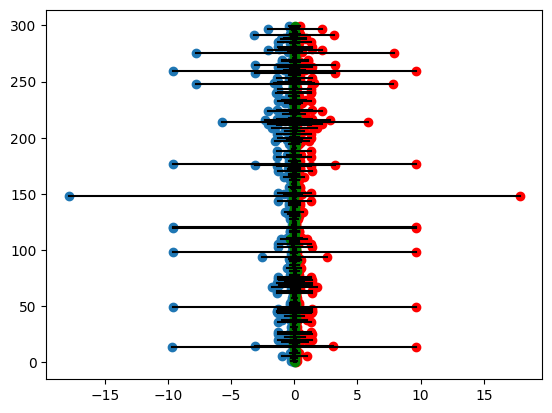

In [6]:
plt.scatter(lowers, list(range(len(yhat))))
plt.scatter(uppers, list(range(len(yhat))), color="red")
plt.scatter(test_data.growthWDI, list(range(len(yhat))), color="green")
for index in range(len(yhat)):
    plt.plot([lowers[index],uppers[index]],[index,index],'k-')
plt.show()

# Bayesian model

In [65]:
# model = pd.read_pickle('../models/nature_reproduction/burke-reproduction-mcmc-fixed-effects-grad-effects-missing-rows-omitted-deterministic-observed.pkl')
model = pd.read_pickle("../models/nature_reproduction/burke-reproduction-mcmc-fixed-effects-grad-effects-deterministic-observed-withheld.pkl")
trace = model["trace"]

In [109]:
bayes_coef1 = trace.posterior.temp_gdp_coef.data.flatten()
bayes_coef2 = trace.posterior.temp_sq_gdp_coef.data.flatten()
bayes_coef3 = trace.posterior.precip_gdp_coef.data.flatten()
bayes_coef4 = trace.posterior.precip_sq_gdp_coef.data.flatten()
intercept = trace.posterior.gdp_intercept.data.flatten()
grad_coefs = np.transpose(np.vstack(trace.posterior.grad_effect_coefs.data))
country_coefs = np.transpose(np.vstack(trace.posterior.country_coefs.data))
year_coefs = np.transpose(np.vstack(trace.posterior.year_coefs.data))

In [110]:
# unscale all model parameters
bayes_coef1 = (bayes_coef1 * np.std(data.growthWDI) / np.std(data.UDel_temp_popweight)) - (2 * (bayes_coef2 * np.mean(data.UDel_temp_popweight * np.std(data.growthWDI)) / np.square(np.std(data.UDel_temp_popweight))))
bayes_coef2 = (bayes_coef2 * np.std(data.growthWDI) / np.square(np.std(data.UDel_temp_popweight)))
bayes_coef3 = (bayes_coef3 * np.std(data.growthWDI) / np.std(data.UDel_precip_popweight)) - (2 * (bayes_coef4 * np.mean(data.UDel_precip_popweight * np.std(data.growthWDI)) / np.square(np.std(data.UDel_precip_popweight))))
bayes_coef4 = (bayes_coef4 * np.std(data.growthWDI)) / np.square(np.std(data.UDel_precip_popweight))
intercept = (intercept * np.std(data.growthWDI)) + np.mean(data.growthWDI) - (bayes_coef1 * np.mean(data.UDel_temp_popweight)) - (bayes_coef2 * np.square(np.mean(data.UDel_temp_popweight))) - (bayes_coef3 * np.mean(data.UDel_precip_popweight)) - (bayes_coef4 * np.square(np.mean(data.UDel_precip_popweight)))
# verify these against stata regression
grad_effect_column_names = list(grad_effect_columns)
for i in range(len(grad_coefs)):
    grad_coefs[i] = (grad_coefs[i] * np.std(data.growthWDI) / np.std(data[grad_effect_column_names[i].replace("x","X")]))
    grad_coefs[i] = [coef if not np.isinf(coef) else 0 for coef in grad_coefs[i]]
for i in range(len(country_coefs)):
    country_coefs[i] = (country_coefs[i] * np.std(data.growthWDI)) + np.mean(data.growthWDI) - (bayes_coef1 * np.mean(data.UDel_temp_popweight)) - (bayes_coef2 * np.square(np.mean(data.UDel_temp_popweight))) - (bayes_coef3 * np.mean(data.UDel_precip_popweight)) - (bayes_coef4 * np.square(np.mean(data.UDel_precip_popweight))) + intercept
for i in range(len(year_coefs)):
    year_coefs[i] = (year_coefs[i] * np.std(data.growthWDI)) + np.mean(data.growthWDI) - (bayes_coef1 * np.mean(data.UDel_temp_popweight)) - (bayes_coef2 * np.square(np.mean(data.UDel_temp_popweight))) - (bayes_coef3 * np.mean(data.UDel_precip_popweight)) - (bayes_coef4 * np.square(np.mean(data.UDel_precip_popweight))) + intercept

/tmp/ipykernel_186092/25637389.py:10: RuntimeWarning: divide by zero encountered in divide
  grad_coefs[i] = (grad_coefs[i] * np.std(data.growthWDI) / np.std(data[grad_effect_column_names[i].replace("x","X")]))


In [111]:
in_range = 0
out_range = 0
predictions = []
real_y = []
min_year = min(data.year)
for row in test_data.iterrows():
    temp = row[1].UDel_temp_popweight
    precip = row[1].UDel_precip_popweight
    country = row[1].iso
    year = row[1].year
    real_y.append(row[1].growthWDI)
    if country == ordered_country_list[0]:
        country_effect = 0
    else:
        country_effect = country_coefs[ordered_country_list.index(country)-1]
    if year - min_year == 0:
        year_effect = 0
    else:
        year_effect = year_coefs[year - min_year -1]
    predict_gdp = (
        temp*bayes_coef1 + 
        np.square(temp)*bayes_coef2 +
        precip*bayes_coef3 +
        np.square(precip)*bayes_coef4 +
        country_effect +
        year_effect +
        intercept
    )
    # grad_effect = 0
    # for i, effect in enumerate(grad_effect_column_names):
    #     grad_effect += row[1][effect] * grad_coefs[i]
    # predict_gdp += grad_effect
    predictions.append(sorted(predict_gdp))

In [112]:
in_range, out_range = 0, 0
interval0, interval1 = [], []
for index, prediction in enumerate(predictions):
    interval = (prediction[int(len(prediction)*.025)],prediction[int(len(prediction)*.975)])
    interval0.append(interval[0])
    interval1.append(interval[1])
    if real_y[index] >= interval[0] and real_y[index] <= interval[1]:
        in_range += 1
    else:
        out_range += 1
print(in_range/len(predictions))
print(out_range/len(predictions))

0.82
0.18


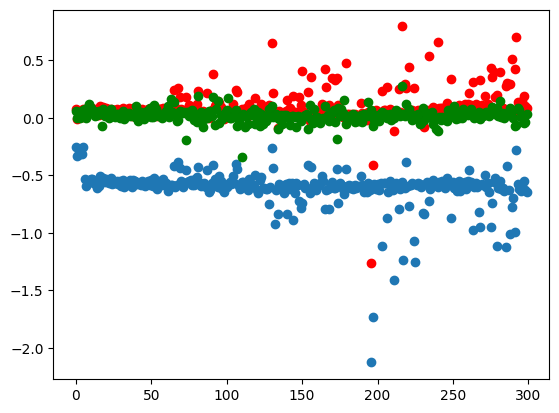

In [113]:
plt.scatter(list(range(len(predictions))), interval0)
plt.scatter(list(range(len(predictions))), interval1, color="red")
plt.scatter(list(range(len(predictions))), real_y, color="green")
plt.show()

# Bootstrap from Stata

In [18]:
bootstrap = pd.read_csv("../data/burke/data/input/burke_stata_bootstrap.csv", header=1)
bootstrap = bootstrap.dropna()

In [19]:
bootstrap_coef1 = bootstrap["_b[temp]"]
bootstrap_coef2 = bootstrap["_b[c.temp#c.temp]"]
bootstrap_coef3 = bootstrap["_b[udel_precip_popweight]"]
bootstrap_coef4 = bootstrap["_b[udel_precip_popweight_2]"]
intercept = bootstrap["_b[_cons]"]

In [20]:
in_range = 0
out_range = 0
yhat = []
real_y = []
for row in test_data.iterrows():
    temp = row[1].UDel_temp_popweight
    precip = row[1].UDel_precip_popweight
    country = row[1].iso
    year = row[1].year
    country_column = f"_b[{str(ordered_country_list.index(country))}.encoded_iso_id]"
    if country_column in bootstrap:
        country_effect = bootstrap[country_column]
    else:
        country_effect = bootstrap[f"_b[{str(ordered_country_list.index(country))}b.encoded_iso_id]"]
    year_column = f"_b[{str(year)}.year]"
    if year_column in bootstrap:
        year_effect = bootstrap[year_column]
    else:
        year_effect = bootstrap[f"_b[{str(year)}b.year]"]
    real_y.append(row[1].growthWDI)
    res = (
        temp*bootstrap_coef1 + 
        np.square(temp)*bootstrap_coef2 + 
        precip*bootstrap_coef3 + 
        np.square(precip)*bootstrap_coef4 +
        country_effect +
        year_effect +
        intercept
    )
    grad_coef_cols = [col for col in list(bootstrap.columns) if "isoxtim" in col]
    for col in grad_coef_cols:
        effect_name = col.split("[")[1].split("]")[0].replace("x","X").replace("o.","")
        res += getattr(row[1],effect_name) * bootstrap[col]
    yhat.append(sorted(res))

In [22]:
in_range, out_range = 0, 0
lowers, uppers = [], []
for index, prediction in enumerate(yhat):
    interval = (prediction[int(len(prediction)*.025)],prediction[int(len(prediction)*.975)])
    lowers.append(interval[0])
    uppers.append(interval[1])
    if real_y[index] >= interval[0] and real_y[index] <= interval[1]:
        in_range += 1
    else:
        out_range += 1
print(in_range/len(yhat))
print(out_range/len(yhat))

0.6733333333333333
0.32666666666666666


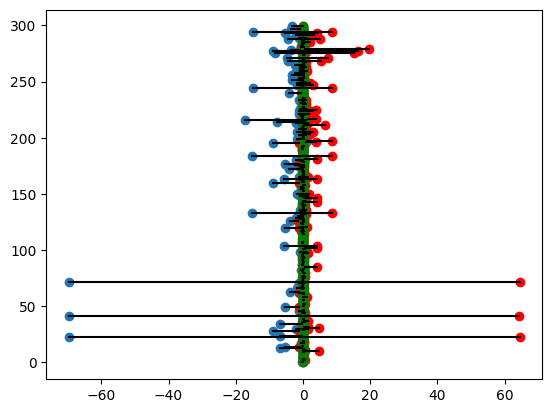

In [23]:
plt.scatter(lowers, list(range(len(yhat))))
plt.scatter(uppers, list(range(len(yhat))), color="red")
plt.scatter(test_data.growthWDI, list(range(len(yhat))), color="green")
for index in range(len(yhat)):
    plt.plot([lowers[index],uppers[index]],[index,index],'k-')
plt.show()

# Ortiz-Bobea data

In [102]:
data = pd.read_csv("../data/ortiz-bobea/data2/regdata_preferred_case.csv")

# Make dataset withholding last 2 years

In [103]:
withheld_rows = []
indices_to_drop = []
years_to_remove = [max(set(data.year)),max(set(data.year))-1]
print(years_to_remove)
for index, row in enumerate(data.itertuples()):
    if row.year in years_to_remove:
        indices_to_drop.append(index)
        withheld_rows.append(row)
data_len_before = len(data)
data_mod = data.drop(indices_to_drop)
data_mod = data_mod.reset_index()
print(f"Removed {data_len_before - len(data_mod)} rows.")

[2015, 2014]
Removed 344 rows.


In [61]:
data_mod.to_csv("../data/ortiz-bobea/data2/regdata_preferred_case_2_years_withheld.csv")

In [104]:
pd.DataFrame(withheld_rows).to_csv("../data/ortiz-bobea/data2/regdata_withheld_rows.csv")

# Bootstrap model from R

In [76]:
bootstrap_data = pd.read_csv("../data/ortiz-bobea/data2/ortiz-bootstrap-2-years-withheld.csv")

In [95]:
bootstrap_data

,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V991,V992,V993,V994,V995,V996,V997,V998,V999,V1000
0,fd_tmean,3.289076e-03,-1.370186e-02,-3.132441e-03,-1.015742e-02,-6.931133e-03,-5.469549e-03,-1.199438e-02,-1.197357e-03,-6.196749e-04,...,-9.663872e-03,-1.161915e-02,-6.527147e-03,-6.142251e-03,-1.162655e-02,-4.499969e-03,4.318363e-03,9.006270e-04,-1.278046e-05,-4.792511e-03
1,fd_tmean_sq,-2.692822e-04,1.501802e-04,-1.763931e-04,6.592168e-05,-3.455810e-05,9.758710e-06,1.045047e-04,-1.381420e-04,-1.829998e-04,...,4.761240e-05,1.026702e-04,-2.375010e-05,-7.407821e-05,1.377640e-04,-9.368356e-05,-3.208511e-04,-2.600290e-04,-1.922279e-04,-3.183785e-05
2,fd_prcp,1.452385e-04,1.913915e-04,2.231023e-04,1.164219e-04,1.795181e-04,2.143084e-04,1.930822e-04,1.935576e-04,2.630718e-04,...,1.932423e-04,1.975461e-04,1.569617e-04,1.292748e-04,1.873167e-04,1.940493e-04,1.678672e-04,1.425452e-04,8.981105e-05,2.560564e-04
3,fd_prcp_sq,-1.523281e-07,-1.781068e-07,-2.545762e-07,-1.041037e-07,-1.653965e-07,-2.081171e-07,-2.011327e-07,-1.972941e-07,-2.823311e-07,...,-2.086525e-07,-1.827401e-07,-1.521158e-07,-1.496929e-07,-1.933785e-07,-1.826971e-07,-1.653563e-07,-1.474798e-07,-8.077690e-08,-2.581454e-07


In [77]:
bootstrap_coef_vals = {}
for row in bootstrap_data.itertuples():
    bootstrap_coef_vals[row[1]] = []
    for i in range(2,1002):
        bootstrap_coef_vals[row[1]].append(row[i])

In [78]:
bootstrap_coef1 = bootstrap_coef_vals["fd_tmean"]b
bootstrap_coef2 = bootstrap_coef_vals["fd_tmean_sq"]
bootstrap_coef3 = bootstrap_coef_vals["fd_prcp"]
bootstrap_coef4 = bootstrap_coef_vals["fd_prcp_sq"]

In [82]:
in_range = 0
out_range = 0
predictions = []
real_y = []
for row in withheld_rows:
    temp = row.tmean
    temp2 = row.tmean_sq
    precip = row.prcp
    precip2 = row.prcp_sq
    real_y.append(row.fd_log_tfp)
    predict_gdp = (temp * np.array(bootstrap_coef1)) + (temp2 * np.array(bootstrap_coef2)) + (precip * np.array(bootstrap_coef3)) + (precip2 * np.array(bootstrap_coef4))
    predictions.append(sorted(predict_gdp))

In [83]:
in_range, out_range = 0, 0
interval0, interval1 = [], []
for index, prediction in enumerate(predictions):
    interval = (prediction[int(len(prediction)*.025)],prediction[int(len(prediction)*.975)])
    interval0.append(interval[0])
    interval1.append(interval[1])
    if real_y[index] >= interval[0] and real_y[index] <= interval[1]:
        in_range += 1
    else:
        out_range += 1
print(in_range/len(predictions))
print(out_range/len(predictions))

0.311046511627907
0.688953488372093


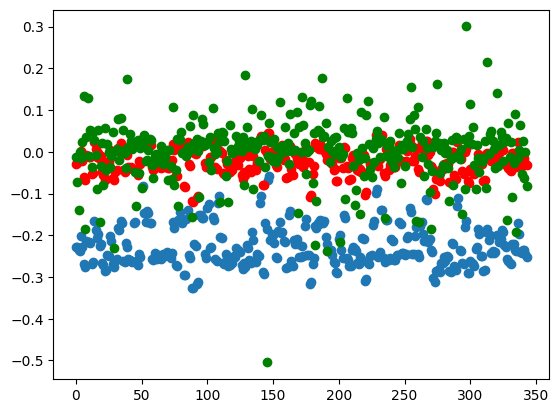

In [85]:
plt.scatter(list(range(len(predictions))), interval0)
plt.scatter(list(range(len(predictions))), interval1, color="red")
plt.scatter(list(range(len(predictions))), real_y, color="green")
plt.show()

# Bayesian model

In [86]:
model = pd.read_pickle('../models/nature_reproduction/ortiz-bobea-reproduction-year-country-fixed-effects-deterministic-observed.pkl')
trace = model["trace"]

In [91]:
bayes_coef1 = trace.posterior.fd_temp_tfp_coef.data.flatten()
bayes_coef2 = trace.posterior.fd_sq_temp_tfp_coef.data.flatten()
bayes_coef3 = trace.posterior.fd_precip_tfp_coef.data.flatten()
bayes_coef4 = trace.posterior.fd_sq_precip_tfp_coef.data.flatten()
intercept = trace.posterior.tfp_intercept.data.flatten()

In [92]:
in_range = 0
out_range = 0
predictions = []
real_y = []
for row in withheld_rows:
    temp = row.tmean
    temp2 = row.tmean_sq
    precip = row.prcp
    precip2 = row.prcp_sq
    real_y.append(row.fd_log_tfp)
    predict_gdp = (temp * bayes_coef1) + (temp2 * bayes_coef2) + (precip * bayes_coef3) + (precip2 * bayes_coef4) + intercept
    predictions.append(sorted(predict_gdp))

In [93]:
in_range, out_range = 0, 0
interval0, interval1 = [], []
for index, prediction in enumerate(predictions):
    interval = (prediction[int(len(prediction)*.025)],prediction[int(len(prediction)*.975)])
    interval0.append(interval[0])
    interval1.append(interval[1])
    if real_y[index] >= interval[0] and real_y[index] <= interval[1]:
        in_range += 1
    else:
        out_range += 1
print(in_range/len(predictions))
print(out_range/len(predictions))

0.9622093023255814
0.0377906976744186


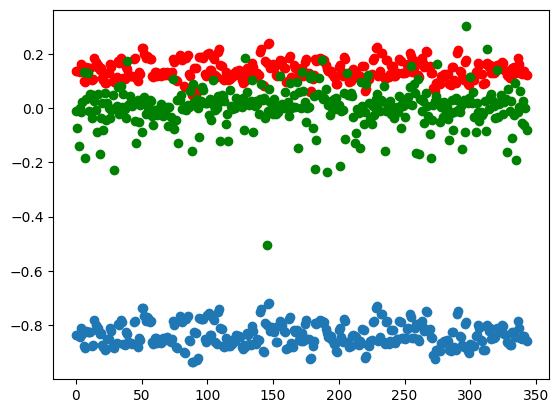

In [94]:
plt.scatter(list(range(len(predictions))), interval0)
plt.scatter(list(range(len(predictions))), interval1, color="red")
plt.scatter(list(range(len(predictions))), real_y, color="green")
plt.show()

# Regression model from R